# Regularization proof of concept


In [11]:
from __helpers import qubit_expansion, prepare_basis, rand_basis, param_to_unitary
from ___constants import PARAM_PER_QUBIT_PER_DEPTH
from __loss_funcs import KL, Em_MMD, MMD
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
import torch as t
from math import pi, cos, sin, exp
from qiskit.quantum_info import Statevector
%matplotlib inline

In [12]:
"""
The below flags control all the main parts of a run. The only things you
would need to change besides these is the optimization parameters, like which
algorithm to use, learning rate, maximum iterations, etc.

When using KL, set `OPS = None`. When using Em_MMD, set `ops = s` 
where `s` is the desired MMD parameter.
"""
CIRCUIT_DEPTH = 0 # Depth of the parameterized quantum circuit
STATE_TYPE = 'GHZ'
NUM_QUBITS = 3
NUM_BASES = 2
USE_REGULARIZER = False
JUMP = True
LOSS_METRIC = KL
ESTIMATE = False
SAMPLE = False
NOISE_SCALE = 5
OPS = None # MMD sigma parameter

          ┌───┐          
q48272_0: ┤ H ├──■────■──
          └───┘┌─┴─┐  │  
q48272_1: ─────┤ X ├──┼──
               └───┘┌─┴─┐
q48272_2: ──────────┤ X ├
                    └───┘


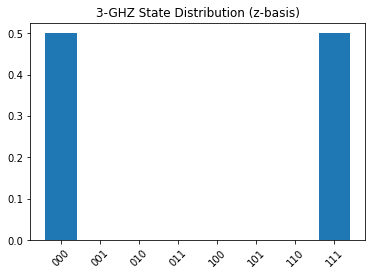

In [13]:
"""[Notes on the states]

Confusingly, the cluster state is actually NUM_QUBITS^2 qubits rather than NUM_QUBITS. 
This is due to the way the circuit is designed. The rest are as you would expect.
"""

if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'mGHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from mGHZ_generator import mGHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = mGHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")
param_shape = (state.num_qubits, CIRCUIT_DEPTH+1, PARAM_PER_QUBIT_PER_DEPTH)

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.xticks(rotation=45)
plt.title(f"{NUM_QUBITS}-{STATE_TYPE} State Distribution (z-basis)")
plt.show()

In [14]:
# Preparation of two bases
bases = prepare_basis(state.num_qubits, num=NUM_BASES)
num_bases = len(bases)

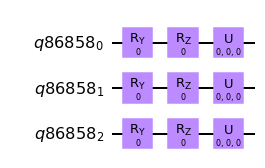

In [26]:
# Start up the HQN
disp = False # Display convergence messages from optimizer

hqn = HQNet(state, bases, eta=1e-2, maxiter=5E3, disp=disp,
            mode='Nelder-Mead', depth=CIRCUIT_DEPTH, 
            estimate=ESTIMATE, s_eps=NOISE_SCALE, 
            metric_func=LOSS_METRIC, ops=OPS, sample=SAMPLE, 
            regularize=USE_REGULARIZER, jump=JUMP,
            checkpoint=700)

# Examine the parametrized circuit
hqn.view_circuit().draw(output='mpl')

In [27]:
# Optimize a few times.
NRUN = 2
param_dim = np.prod(param_shape)
proposed_syms = t.zeros((NRUN, param_dim))
avg = 0
x0 = np.array([3.1416, 1.8676, 3.9111, 3.1416, 0.0572, 3.4207, 3.1416, 1.2177, 8.6164]) # Off diag
# x0 = np.array([6.2832, 4.6871, 1.5150, 6.2832, 6.8319, 1.4635, 6.2832, 7.3298, 2.4352]) # diag
# x0 = None # random
for i in range(NRUN):
    if disp:
        print(f"== Run {i+1}/{NRUN} ==")
    potential_sym, loss, regularizer_loss = hqn.find_potential_symmetry(print_log=True, x0=x0)
    if USE_REGULARIZER or JUMP:
        print(f"Regularizer loss = {regularizer_loss}")
    proposed_syms[i] = potential_sym if t.is_tensor(potential_sym) else t.from_numpy(potential_sym)
    potential_sym = potential_sym.reshape(param_shape)
    if disp:
        print(f"Proposed symmetry:\n{potential_sym}\n")
    avg += loss / NRUN
print(f"\nAverage loss: {avg}")

Jumped 1 times
Optimized to loss metric = 2.6660505400566414e-11
Queried loss func 697 times
Regularizer loss = [3.2148932e-03 1.8570027e-08]
Jumped 2 times
Optimized to loss metric = 1.8697722536931138e-10
Queried loss func 700 times
Regularizer loss = [1.2777367e-06 5.4027228e-06]

Average loss: 1.068188653849389e-10


## Quantum Training Validation

In [28]:
# Look at the final KL divergence in each of the chosen bases.
for i, sym in enumerate(proposed_syms):
    for j, basis_here in enumerate(bases):
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"[B{j}] KL = {loss_metric}")

[B0] KL = -3.353195320466619e-17
[B1] KL = 2.5762056203719716e-11
[B0] KL = 4.777569416570891e-11
[B1] KL = 1.388390962905702e-10


## Quantum Loss Cross-Validation

In [29]:
# Choose some random bases to examine.
NUM_RAND_BASES = 3 # arbitrary
for i, sym in enumerate(proposed_syms):
    for j in range(NUM_RAND_BASES):
        basis_here = rand_basis(state.num_qubits)
        loss_metric = PQC(state, depth=CIRCUIT_DEPTH, basis_param=basis_here, 
                          metric_func=KL, say_hi=False).evaluate_true_metric(sym)
        print(f"[B{j}] KL = {loss_metric}")

[B0] KL = 1.9732549609153822e-05
[B1] KL = 2.4902047153630474e-08
[B2] KL = 4.67334016916452e-05
[B0] KL = 1.8557865532343333e-08
[B1] KL = 4.4255048974789375e-10
[B2] KL = 6.60006001949471e-05


## Regularization validation

In [30]:
# Convert the proposed symmetries to unitaries
for i, sym in enumerate(proposed_syms):
    sym = sym.reshape((NUM_QUBITS, -1)).numpy()
    unitary = np.around(param_to_unitary(sym), 4)
    print(f"[S{i}] Operator = \n {unitary}")

[S0] Operator = 
 [[[-1.    +0.j      0.    -0.j    ]
  [-0.    +0.j      0.2423+0.9702j]]

 [[-1.    +0.j     -0.    +0.j    ]
  [ 0.    -0.j     -0.2686+0.9632j]]

 [[ 1.    +0.j      0.    +0.j    ]
  [ 0.    -0.j     -0.7887+0.6148j]]]
[S1] Operator = 
 [[[ 0.000e+00+0.j      6.174e-01-0.7867j]
  [ 2.935e-01+0.9559j -0.000e+00-0.j    ]]

 [[ 1.000e-04+0.j      2.468e-01-0.9691j]
  [ 3.630e-02+0.9993j -1.000e-04-0.j    ]]

 [[-0.000e+00+0.j      9.461e-01+0.3237j]
  [ 9.494e-01+0.3141j  0.000e+00+0.j    ]]]


In [31]:
print(proposed_syms[0])

tensor([6.2832e+00, 1.9575e+00, 2.5101e+00, 6.2832e+00, 5.6669e+00, 5.6006e+00,
        1.5372e-06, 4.9532e+00, 3.8094e+00])
